In [3]:
%reload_ext autoreload
%autoreload 2

from typing import Any
import jax
import jax.numpy as jnp

import flax.linen as nn
from flax.training import common_utils

import ml_collections

%cd /hildafs/projects/phy230056p/junzhez/AI/maskgit
%ls
import maskgit
from maskgit.utils import visualize_images, read_image_from_url, draw_image_with_bbox, Bbox
from maskgit.inference import ImageNet_class_conditional_generator
from maskgit.nets import layers

import matplotlib.pyplot as plt

/hildafs/projects/phy230056p/junzhez/AI/maskgit
checkpoints/     gmmg/  LICENSE   MaskGIT_demo.ipynb  requirements.txt
CONTRIBUTING.md  imgs/  maskgit/  README.md


/hildafs/projects/phy230056p/junzhez/.conda/envs/AI_torch/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## A simple convolutional layer

/tmp/ipykernel_1001003/3170561536.py:30: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  print(jax.tree_map(lambda x: x.shape, variables))


{'params': {'Conv_0': {'bias': (128,), 'kernel': (3, 3, 3, 128)}, 'Conv_1': {'kernel': (3, 3, 128, 128)}}}
Input shape: (2, 32, 32, 3)
Output shape: (2, 8, 8, 128)


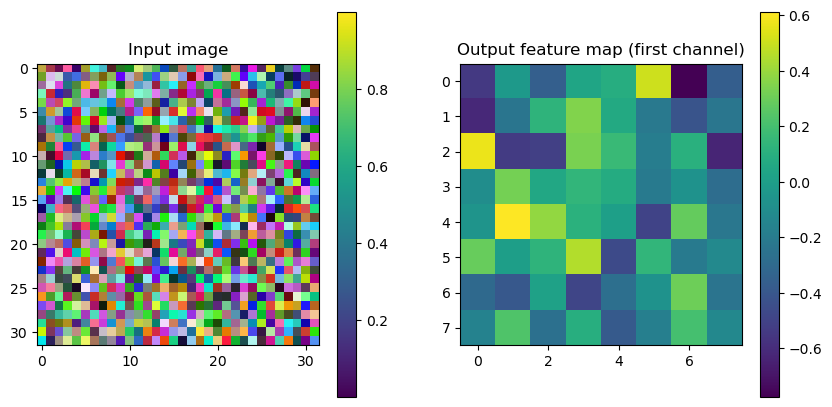

In [5]:
def dummy_images():
    batch_size = 2
    height = 32
    width = 32
    channels = 3
    images = np.random.rand(batch_size, height, width, channels).astype(np.float32)
    return images

class SimpleConvNet(nn.Module):
    num_filters: int

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=self.num_filters, kernel_size=(3, 3), strides=(2, 2))(x) # default has bias
        x = nn.Conv(features=self.num_filters, kernel_size=(3, 3), strides=(2, 2), use_bias=False)(x) # no bias
        return x

def main():
    rng = jax.random.PRNGKey(0)

    # input data
    images = dummy_images()

    # set up the model
    num_filters = 128
    model = SimpleConvNet(num_filters=num_filters)
    variables = model.init(rng, images) # model weights, which are randomly initialized

    # use tree_map to print the shapes of the model weights
    print(jax.tree_map(lambda x: x.shape, variables))

    # Apply the model to the dummy images
    output = model.apply(variables, images)
    return images, output

images, output = main()

print(f"Input shape: {images.shape}") # (2, 64, 64, 3)
print(f"Output shape: {output.shape}") # (2, 32, 32, 128)

# show the images

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
c = plt.imshow(images[0])
plt.colorbar(c)
plt.title("Input image")
plt.subplot(1, 2, 2)
c = plt.imshow(output[0, :, :, 0])
plt.colorbar(c)
plt.title("Output feature map (first channel)")
plt.show()


## The Residual and the Encoder blocks

### jargons
- the term `filter` or `kernel` refers to a set of learnable weights (a small matrix of weights, or parameters) that is used to scan across the input data (e.g., an image) and perform element-wise multiplication followed by summation.
- the `number of filters` in a convolutional layer is the number of filters that are used to scan across the input data, it determines the number of output channels (also called feature maps) produced by that layer. Each filter produces one output channel.
    - here we use 128 filters in the initial convolutional layer, meaning *we use 128 different kernels to scan across the input image, producing 128 output maps (channels, or `feature maps`)*.
    - when a filter scans across the input data, it produces a feature map for each channel in the input data (e.g., the RGB channels in an image), it then *sums these feature maps to produce a single output map*.
### The encoder block
1. Initial Convolution:
    * Input shape: (batch_size, height, width, channels)
    * Output shape: (batch_size, height, width, filters)
2. Residual Blocks:
    * For each channel multiplier stage:
        * Apply `num_res_blocks` residual blocks.
        * Downsample if required (e.g., halving height and width).
3. Final Convolution:
    * Normalize and activate the features.
    * Apply the final convolution to reach the `embedding_dim`.


In [ ]:
from maskgit.nets import layers
from maskgit.nets.vqgan_tokenizer import ResBlock, Encoder

In [ ]:
from ml_collections import ConfigDict
def get_config():
    config = ConfigDict()
    config.vqvae = ConfigDict()
    config.vqgan = ml_collections.ConfigDict()
    config.vqgan.loss_type = "non-saturating"
    config.vqgan.g_adversarial_loss_weight = 0.1
    config.vqgan.gradient_penalty = "r1"
    config.vqgan.grad_penalty_cost = 10.0

    config.vqvae = ml_collections.ConfigDict()
    config.vqvae.quantizer = "vq"
    config.vqvae.codebook_size = 1024

    config.vqvae.entropy_loss_ratio = 0.1
    config.vqvae.entropy_temperature = 0.01
    config.vqvae.entropy_loss_type = "softmax"
    config.vqvae.commitment_cost = 0.25

    # number of filters in Encoder/Decoder
    config.vqvae.filters = 128
    # 
    config.vqvae.num_res_blocks = 2
    # the number of filters at each stage of the encoder/decoder
    config.vqvae.channel_multipliers = [1, 1, 2, 2, 4]
    config.vqvae.embedding_dim = 256
    config.vqvae.conv_downsample = False
    config.vqvae.activation_fn = "swish"
    config.vqvae.norm_type = "GN"
    return config

config = get_config()

In [ ]:
# Create Dummy Input Tensor
batch_size = 32
height = 256
width = 256
channels = 3
dummy_input = jnp.ones((batch_size, height, width, channels), dtype=jnp.float32)

# Initialize and Test the Encoder
encoder = Encoder(config=config, train=False)

# Initialize the parameters
rng = jax.random.PRNGKey(0)
params = encoder.init(rng, dummy_input)

# Apply the encoder to the dummy input
encoded_output = encoder.apply(params, dummy_input)

# Print the shapes of the input and output tensors
print("Input shape:", dummy_input.shape)
print("Output shape:", encoded_output.shape)

Input shape: (32, 256, 256, 3)
Output shape: (32, 64, 64, 128)


In [ ]:
jax.tree_map(lambda x: x.shape, params['params'])

/tmp/ipykernel_163252/2457492338.py:1: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  jax.tree_map(lambda x: x.shape, params['params'])


{'BatchNorm_0': {'bias': (256,), 'scale': (256,)},
 'Conv_0': {'kernel': (3, 3, 3, 64)},
 'Conv_1': {'bias': (64,), 'kernel': (4, 4, 64, 64)},
 'Conv_2': {'bias': (128,), 'kernel': (4, 4, 128, 128)},
 'Conv_3': {'bias': (128,), 'kernel': (1, 1, 256, 128)},
 'ResBlock_0': {'BatchNorm_0': {'bias': (64,), 'scale': (64,)},
  'BatchNorm_1': {'bias': (64,), 'scale': (64,)},
  'Conv_0': {'kernel': (3, 3, 64, 64)},
  'Conv_1': {'kernel': (3, 3, 64, 64)}},
 'ResBlock_1': {'BatchNorm_0': {'bias': (64,), 'scale': (64,)},
  'BatchNorm_1': {'bias': (64,), 'scale': (64,)},
  'Conv_0': {'kernel': (3, 3, 64, 64)},
  'Conv_1': {'kernel': (3, 3, 64, 64)}},
 'ResBlock_2': {'BatchNorm_0': {'bias': (64,), 'scale': (64,)},
  'BatchNorm_1': {'bias': (128,), 'scale': (128,)},
  'Conv_0': {'kernel': (3, 3, 64, 128)},
  'Conv_1': {'kernel': (3, 3, 128, 128)},
  'Conv_2': {'kernel': (1, 1, 128, 128)}},
 'ResBlock_3': {'BatchNorm_0': {'bias': (128,), 'scale': (128,)},
  'BatchNorm_1': {'bias': (128,), 'scale': (1

### Dimensionality progression

```        
x = conv_fn(self.filters, kernel_size=(3, 3), use_bias=False)(x)
num_blocks = len(self.channel_multipliers)
for i in range(num_blocks):
    filters = self.filters * self.channel_multipliers[i]
    for _ in range(self.num_res_blocks):
        x = ResBlock(filters, **block_args)(x)
    if i < num_blocks - 1:
        if self.conv_downsample:
            x = conv_fn(filters, kernel_size=(4, 4), strides=(2, 2))(x)
        else:
            x = layers.dsample(x)
for _ in range(self.num_res_blocks):
    x = ResBlock(filters, **block_args)(x)
x = norm_fn()(x)
x = self.activation_fn(x)
x = conv_fn(self.embedding_dim, kernel_size=(1, 1))(x)
return x
```
**Input**: (batch_size, height, width, channels)

1. **Initial Convolution**:
    * Input: (batch_size, height, width, channels)
    * Output: (batch_size, height, width, 128)

2. **Stage 1** (with `channel_multiplier=1`):
    * **Residual Block 1**: (batch_size, height, width, 128)
    * **Residual Block 2**: (batch_size, height, width, 128)
    * **Output**: (batch_size, height, width, 128)

3. **Stage 2** (with `channel_multiplier=1`):
    * **Residual Block 1**: (batch_size, height, width, 128)
    * **Residual Block 2**: (batch_size, height, width, 128)
    * **Output**: (batch_size, height, width, 128)

4. **Stage 3** (with `channel_multiplier=2`):
    * **Residual Block 1**: (batch_size, height, width, 256)
    * **Residual Block 2**: (batch_size, height, width, 256)
    * **Output**: (batch_size, height, width, 256)

5. **Stage 4** (with `channel_multiplier=2`):
    * **Residual Block 1**: (batch_size, height, width, 256)
    * **Residual Block 2**: (batch_size, height, width, 256)
    * **Output**: (batch_size, height, width, 256)

6. **Stage 5** (with `channel_multiplier=4`):
    * **Residual Block 1**: (batch_size, height, width, 512)
    * **Residual Block 2**: (batch_size, height, width, 512)
    * **Output**: (batch_size, height, width, 512)

7. **Final Processing**:
    * **Normalization and Activation**: (batch_size, height, width, 512)
    * **Final Convolution**: (batch_size, height, width, 256)
